### FCM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fcm_function import *
from sklearn.preprocessing import StandardScaler
import numpy as np
import skfuzzy as fuzz

In [2]:
# load file & and normalize with z_score
file_path = 'forestfires.csv'
df = pd.read_csv(file_path)
small_data = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH']]
for col in small_data.columns:
    # small_data[col] = normalization_range(small_data[col])
    small_data[col] = normalization_zscore(small_data[col])

# print(small_data.values)


C:\Users\rafae\AppData\Local\Temp\ipykernel_12864\1122092979.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_data[col] = normalization_zscore(small_data[col])


### (b) Plot the FCM clustering criterion (i.e. the cost function) as a function of c.

In [ ]:
def FCM_cost_function(X, c, m, error, maxiter):
    '''
    Args:
    X : data, size (p, n), n samples of p features.
    c : number of clusters.
    m : Weighting exponent (Fuzziness degree).
    error : Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : Maximum number of iterations allowed.
    jm : Objective function.
    '''
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled.T, c, m, error, max_iterations, init=None)
    return jm

# Data & Parameters
X_scaled = small_data.values
c_min = 2
c_max = 5
m = 2
error = 0.005
max_iterations = 1000

# Plotting cost functions for different c
plt.figure(figsize=(8, 6))
for c in range(c_min, c_max + 1):
    jm = FCM_cost_function(X_scaled, c, m, error, max_iterations)
    plt.plot(jm, label=f'c={c}')  # Plot cost function with label c

plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('FCM Objective Function for Different Number of Clusters')
plt.legend(loc='best')  # Add legend to differentiate each line
plt.grid(True)
plt.show()

# c) (Iterative) Anomalous Pattern (IAP) clustering algorithm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('forestfires.csv')

def IAP_clustering(X, c, m, error, maxiter):
    """
    Iterative Anomalous Pattern (IAP) clustering algorithm.
    
    Args:
    X : data, size (p, n), n samples of p features.
    c : number of clusters.
    m : Weighting exponent (Fuzziness degree).
    error : Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : Maximum number of iterations allowed.
    
    Returns:
    cntr : Final cluster centers.
    u : Final fuzzy partition matrix.
    
    """
    # Step 1: Identify anomalous points using an outlier detection method (e.g., Z-score, LOF)
    outlier_threshold = 2.0  # Z-score threshold
    z_scores = np.abs((X - X.mean(axis=0)) / X.std(axis=0))
    anomaly_mask = np.any(z_scores > outlier_threshold, axis=1)
    
    # Step 2: Remove anomalies from initial clustering
    X_clean = X[~anomaly_mask]
    
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_clean.T, c, m, error, maxiter, init=None)
    return cntr, u, jm, X_clean

In [ ]:
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Normalize the data
#scaler = StandardScaler()
X_scaled = normalization_zscore(X)

In [ ]:
# Parameters
c = 3  # Number of clusters
m = 2  # Fuzziness degree
error = 0.005  # Stopping criterion
maxiter = 1000  # Maximum number of iterations

# Apply IAP clustering
cntr, u, jm, X_clean = IAP_clustering(X_scaled, c, m, error, maxiter)

Silhouette Score: 0.530396358128612


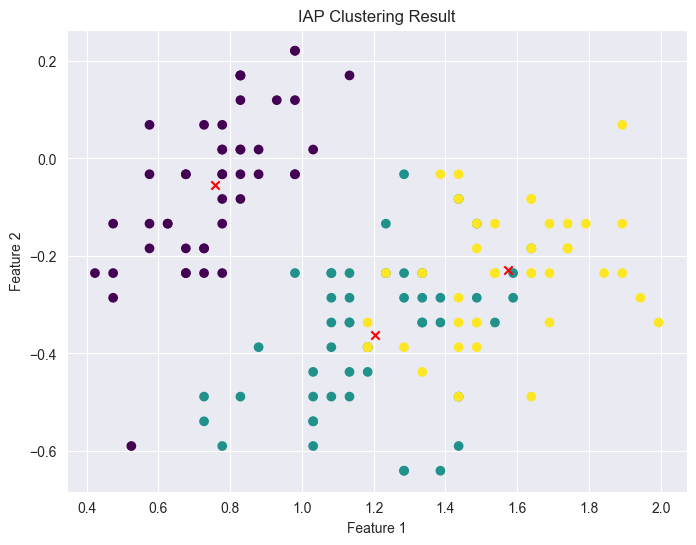

In [10]:
# Assign clusters based on the highest membership value
cluster_labels = np.argmax(u, axis=0)

# Calculate silhouette score
sil_score = silhouette_score(X_clean, cluster_labels)
print(f'Silhouette Score: {sil_score}')

# Visualize the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_clean[:, 0], X_clean[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x')  # Cluster centers
plt.title('IAP Clustering Result')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### d) 
Take the Anomalous Clustering as the initialization algorithm to the fuzzy c-means and apply the
Anomalous Patterns FCM to your data set. Discuss the option taken for setting its stop condition. Present
and visualize the found fuzzy partitions of AP-FCM taking advantage of the PCA visualization (check PCA
tutorial).

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz

In [12]:
df = pd.read_csv('forestfires.csv')
small_data = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH']]

normalized_data = normalization_zscore(small_data)

In [13]:
# ---- IAP Clustering Function ----
def IAP_clustering(X, c, m, error, maxiter):
    """
    Iterative Anomalous Pattern (IAP) clustering algorithm.

    Args:
    X : Normalized data, shape (n_samples, n_features).
    c : Number of clusters.
    m : Fuzziness degree.
    error : Stopping criterion.
    maxiter : Maximum iterations.

    Returns:
    cntr : Final cluster centers.
    u : Membership matrix.
    X_clean : Data after anomaly removal.
    """
    outlier_threshold = 2.0  # Z-score threshold
    z_scores = np.abs((X - X.mean(axis=0)) / X.std(axis=0))
    anomaly_mask = np.any(z_scores > outlier_threshold, axis=1)
    
    # Remove anomalies
    X_clean = X[~anomaly_mask]

    # Run fuzzy c-means on the cleaned data
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        X_clean.T, c, m, error, maxiter, init=None)

    return cntr, u, X_clean

In [14]:
# ---- Apply IAP Clustering ----
c = 3  # Number of clusters
m = 2  # Fuzziness degree
error = 0.005  # Stop condition
maxiter = 1000  # Max iterations

cntr_init, _, X_clean = IAP_clustering(X_scaled, c, m, error, maxiter)

In [15]:
# Assign clusters based on max membership
cluster_labels = np.argmax(u, axis=0)

# Calculate silhouette score
sil_score = silhouette_score(X_clean, cluster_labels)
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.5304


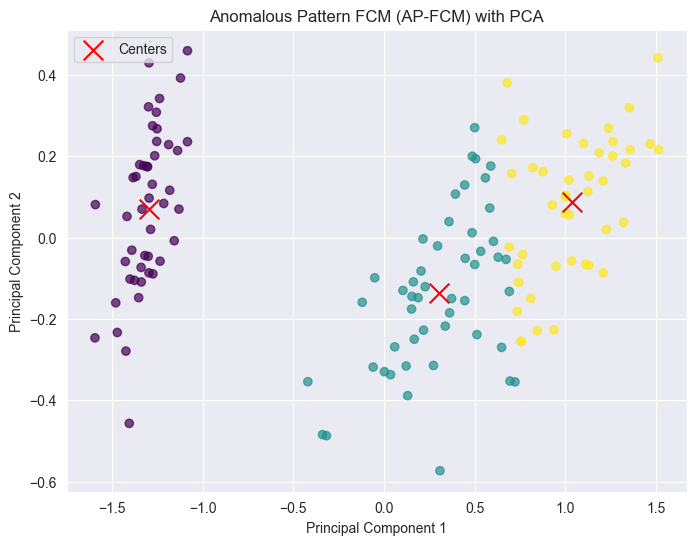

In [16]:
# ---- PCA for Visualization ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.scatter(pca.transform(cntr)[:, 0], pca.transform(cntr)[:, 1], c='red', marker='x', s=200, label='Centers')
plt.title('Anomalous Pattern FCM (AP-FCM) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

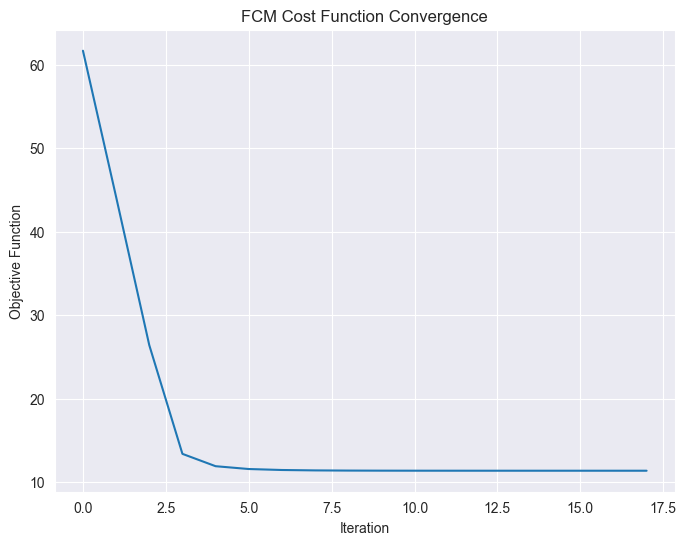

In [17]:
# ---- Plot the FCM Cost Function ----
plt.figure(figsize=(8, 6))
plt.plot(jm)
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('FCM Cost Function Convergence')
plt.grid(True)
plt.show()